# Imports

In [1]:
from pipeline import loading_pipeline
from model_training import PyTorchModel
from model_training import evaluate_classification_model
import torch
import torch.nn as nn
import numpy as np

In [2]:
X_train, y_train, X_test, y_test = loading_pipeline()

Number of samples: 8600
Signal Length: 2816
X-Shape: (8100, 1408, 2)
y-Shape: (8100,)
X-Shape: (500, 1408, 2)
y-Shape: (500,)
Augmented X.shape: (72900, 1152, 2)
Augmented y.shape: (72900,)
Trimmed X.shape: (500, 1152, 2)


In [8]:
unique, counts = np.unique(y_train, return_counts=True)
class_balance = dict(zip(unique, counts))

print("Class Balance:")
for class_label, count in class_balance.items():
    print(f"Class {class_label}: {count} samples")

Class Balance:
Class 0: 40500 samples
Class 1: 8100 samples
Class 2: 8100 samples
Class 3: 8100 samples
Class 4: 8100 samples


# LSTM

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [4]:
# Initialize the LSTM model
input_size = X_train.shape[2]  # Number of features per time step
num_classes = len(np.unique(y_train))  # Number of unique classes
hidden_size = 128  # Can be adjusted
num_layers = 2  # Can be adjusted

lstm_model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# PyTorchModel Wrapper
model = PyTorchModel(lstm_model, criterion, optimizer, device)

Epoch [1/25], Train Loss: 1.1558, Val Loss: 0.8844
Epoch [2/25], Train Loss: 0.9968, Val Loss: 0.8845
Epoch [3/25], Train Loss: 0.8961, Val Loss: 0.8815
Epoch [4/25], Train Loss: 0.8956, Val Loss: 0.8807
Epoch [5/25], Train Loss: 0.9152, Val Loss: 0.8815
Epoch [6/25], Train Loss: 0.8951, Val Loss: 0.8801
Epoch [7/25], Train Loss: 0.8947, Val Loss: 0.8811
Epoch [8/25], Train Loss: 0.9148, Val Loss: 0.8810
Epoch [9/25], Train Loss: 0.9173, Val Loss: 0.9064
Early stopping triggered
Accuracy: 0.2
Precision: 0.04
Recall: 0.2
F1-Score: 0.06666666666666667


/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


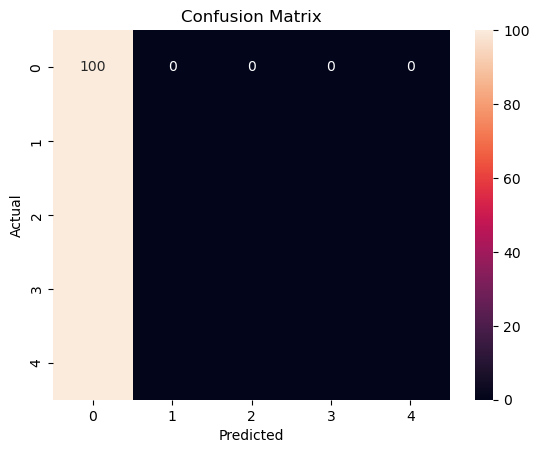


Classification Report:

              precision    recall  f1-score   support

           0       0.20      1.00      0.33       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100

    accuracy                           0.20       500
   macro avg       0.04      0.20      0.07       500
weighted avg       0.04      0.20      0.07       500


/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/davidokel/miniconda3/envs/ml_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [5]:
evaluate_classification_model(model, X_train, y_train, X_test, y_test)